# Preprocessing of MIMIC-CXR dataset

This notebook illustrates how week supervision can be applied on medical images and the corresponding reports. Since there are two sources of data (images and reports) we establish a double layer week supervision. 

In this example the MIMIC-CXR dataset is used. There are to versions of this dataset: 

[MIMIC-CXR](https://physionet.org/content/mimic-cxr/2.0.0/) Database (Johnson, Pollard et al. (2019) is a large publicly available dataset of chest X-rays including radiology reports. It contains 377110 images and 227835 radiographic studies. A radiographic study consists of one report and one or multiple images. 

[MIMIC-CXR-JPG](https://physionet.org/content/mimic-cxr-jpg/2.0.0/) Database (Johnson, Lungren et al. (2019) bases on MIMIC-CXR. It additionally includes weak labels which are derived from the radiology reports using CheXpert labler (Irvin, Rajpurkar et al. 2019) and the images are in JPG format instead of DICOM format. 

Neiter versions of the MIMIC-CXR dataset have gold labels. Since both the CheXpert data and the MIMIC-CXR data contain chest X-Rays, the CheXpert labler was used in the MIMIC-CXR-JPG Database to obtain week labels. We will use a small subset of the MIMIC images and their week labels in the data preprocessing to finetune our image encoder CNN. Apart from that we do not touch any labels until evaluation.
To evaluate our results in the end, we apply the trained model (Knodle output) to the validation data of the CheXpert dataset, since they have gold labels. 

Below we provided a little sketch of the pipeline implemented.
In the data preprocessing we build the three input matrices knodle requires:
 * The rules are generated from the CheXpert Labler phrases. The phrases contain mentions (synonyms or related words) for each class, which we use to build our T matrix, so the "rule to class" matrix. 
 * The Z matrix, so the "rule matches" matrix is generated from the reports and the rules. 
 * The images are encoded with a CNN. We try two different approaches: 1) CNN with pretrained weight without finetuning and 2) CNN with pretrained weights and finetuning. Therefore, we need the week labels. 
 
These matrices will be stored as:
* T: "mapping_rules_labels_t.lib"
* Z: "rule_matches_z.lib"
* X: "all_X.lib" and "all_X_finetuned.lib"

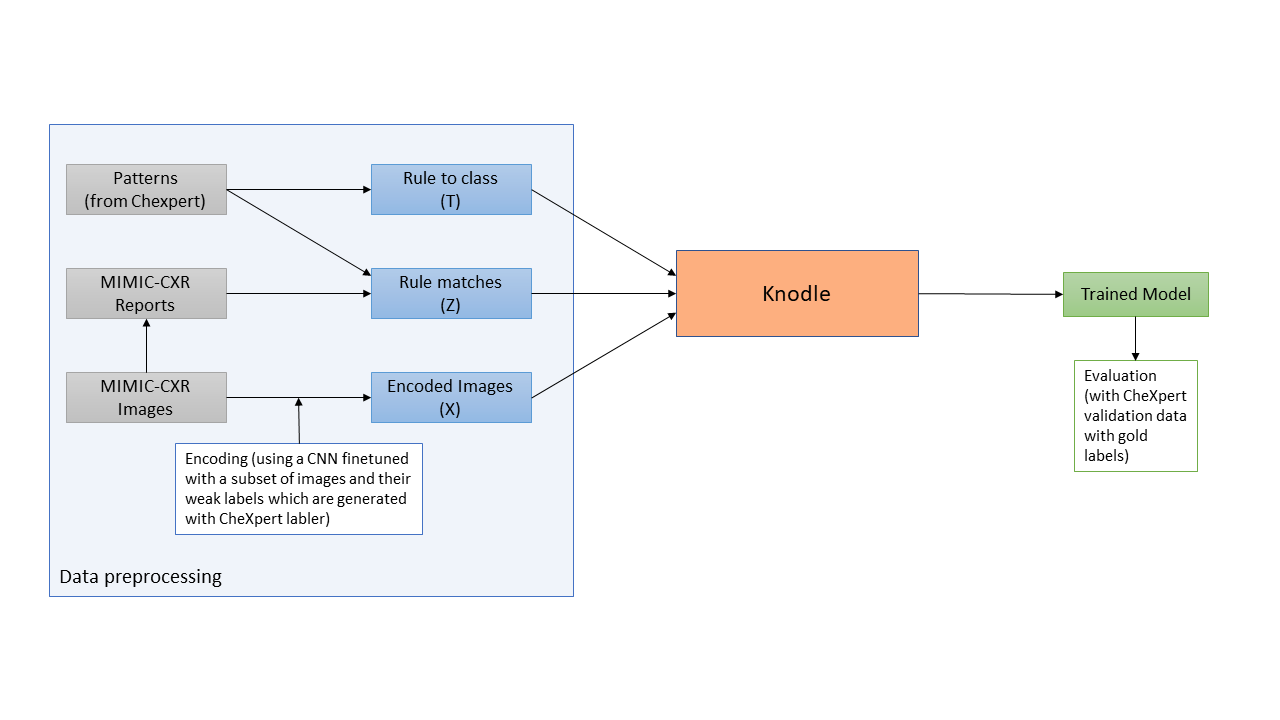

## Imports

First, let's make some basic imports.

In [ ]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import random
import copy
import csv
import itertools

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from typing import Dict
from joblib import dump, load
from PIL import Image

## Getting all set up

To get access to the data, one needs to be a "credential user" in PhysioNet and sign the data use agreement. To be able to run this tutorial yourself, the following steps should be conducted:
1. To get a credentialed PhysioNet account, follow the following [instructions](https://physionet.org/about/citi-course/). 
2. Then sign the data use agreement for both, the MIMIC-CXR and the MIMIC-CXR-JPG database.
3. Check if `wget` is installed on your device, it will be used to download the data directly from PhysioNet.
4. Set your working directory to a prefered folder. The data will be downloaded into this folder. 
5. Check if you have enough memory space in the current directory (all images are 557.6 GB, the first 1000 images are 1.51GB large)
6. Set n (number of images which should be downloaded)
7. Insert your PhysioNet username and password

In [2]:
#os.chdir("")
# set n between 1 and 377110
n = 1000

In [ ]:
# PhysioNet
USERNAME = "your_username_here"
PASSWORD = "your_pw_here"

# Downloads

The following code will download some files we will need directly from PhysioNet:
* `"cxr-record-list.csv.gz"` (from mimic-cxr),
* `"cxr-study-list.csv.gz"` (from mimic-cxr),
* `"mimic-cxr-reports.zip"` (from mimic-cxr),
* `"mimic-cxr-2.0.0-chexpert.csv.gz"` (from mimic-cxr-jpg)

The first file contains the paths we need to download the actual images in the next stage. The second file contains the paths for the report files TXT files. Those we will need to read in the reports. The third download is the zip-folder of all reports. The last file contains the chexpert results, where we will extract our week labels from.

This can take a while (it took us 260 minutes).

In [ ]:
# downloads from mimic-cxr
url = ["wget -N -c -np --user=", USERNAME, " --password=", PASSWORD, " https://physionet.org/files/mimic-cxr/2.0.0/"]

command = "".join(url+["cxr-record-list.csv.gz"]) # paths to images
os.system(command)
command = "".join(url+["cxr-study-list.csv.gz"]) # paths to reports
os.system(command)
command = "".join(url+["mimic-cxr-reports.zip"]) # folder of all reports
os.system(command)

# downloads from mimic-cxr-jpg
url = ["wget -N -c -np --user=", USERNAME, " --password=", PASSWORD, " https://physionet.org/files/mimic-cxr-jpg/2.0.0/"]
command = "".join(url+["mimic-cxr-2.0.0-split.csv.gz"]) # train/val/test split information
os.system(command)
command = "".join(url+["mimic-cxr-2.0.0-chexpert.csv.gz"]) # chexpert output for mimic dataset
os.system(command)

Now **unzip** all files and the folder of reports with 7zip.

#### Downloading MIMIC-CXR-JPG images

Next, we are going to download the X-ray images. Since the full dataset is  557.6GB large, we want to allow to download only a subset of images. Here we will download the first n images according to the order from the "record_list" file. 

In [3]:
record_list = pd.read_csv("cxr-record-list.csv").to_numpy()
study_list = pd.read_csv("cxr-study-list.csv").to_numpy()

In [ ]:
# image download
for i in tqdm(range(1000,n)):
    url = ["wget -N -c -np --user=", USERNAME, " --password=", PASSWORD, " https://physionet.org/files/mimic-cxr-jpg/2.0.0/",record_list[i,3]]
    command = "".join(url)
    command = "".join([command.replace(".dcm", ""),".jpg -P ",record_list[i,3]])
    os.system(command)

We are done with downloading, now let's process the data.

## Processing the reports

The reports are all stored in seperate TXT files. Each report has the following structure:

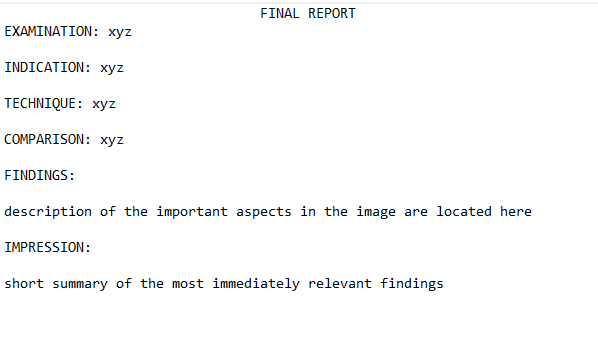


We process the reports so that we get one file for all reports in the CSV format where each report is saved in a separate row. We extract the "Findings" and "Impressions" sections from each report and save it to one CSV. 

In [ ]:
with open('mimic_cxr_text.csv', 'w', newline='', encoding='utf-8') as f:
    for i in tqdm(range(len(study_list))):
        with open(''.join(["mimic-cxr-reports/", study_list[i,2]])) as f_path:
            text = ''.join(f_path.readlines())
        text = text.replace("\n", "")
        text = text.replace(",", "")
        start = text.find("FINDINGS:")
        end = text.find("IMPRESSION:")
        findings = text[start:end]
        impressions = text[end:len(text)]
        row = [study_list[i,0],study_list[i,1], findings, impressions]
        csvwriter = csv.writer(f)
        csvwriter.writerow(row)

In [4]:
# open the file we built above
reports = pd.read_csv("mimic_cxr_text.csv", names = ["subject_id","study_id", "findings", "impressions"], na_values='.')

Let's get an overview of the reports. We calculate the average length of the finding and impression section. 

In [5]:
print("average length findings section:", np.mean(reports["findings"].str.len()))

print("average length impression section:", np.mean(reports["impressions"].str.len()))

average length findings section: 348.6685509250907
average length impression section: 193.16239243554105


The section "Findings" contains a description of the important aspects in the image, while the section "Impression" gives a short summary of the most immediately relevant findings. In the current preprocessing, we use the "Impression" section or, if impressions are not available, the "Finding" section instead. The reports that do not contain any impression or findings sections (about 5% of all reports) are ignored in this analysis.

In [6]:
print("proportion of NAs in findings and impressions:", pd.isna(reports[['findings', 'impressions']]).sum()/len(reports))

proportion of NAs in findings and impressions: findings       0.343117
impressions    0.174214
dtype: float64


In [7]:
# if impression is missing insert finding
reports.impressions.fillna(reports.findings, inplace=True)
# if non of both are there, we do not analyse this study
del reports['findings']
reports_processed = reports.dropna()

Now we merge the reports to our record list such that each image gets a report assigned if a report is available. 
If a report refers to multiple images, the report is merged to all refered images.

In [8]:
# merge reports to record_list
record_list = pd.read_csv("cxr-record-list.csv")
record_report_list = pd.merge(record_list, reports_processed, how = 'left', on= ['study_id','subject_id'])

## Add labels
In this section, we build an array, which contains all relevant information about the images (id, path, label). The "cxr_record_list.csv" contains the columns (`subject_id`,`study_id`,`dicom_id`) which all together form a unique ID and `path`. Now we want to merge the labels information to each image.  

But before we can do that, we need to extract the labels from the CheXpert output.

### Labels

The CheXpert labler detect the presence of 14 diagnoses in radiology reports. 
"mimic-cxr-2.0.0-chexpert.csv" contains one column for each of the 14 diagnoses and one row for each study. Each study and each diagnosis has assigned one of the four values: 1.0,-1.0, 0.0 or missing. They have the following interpretation:

* 1.0 The label was positively mentioned in the associated study, and is present in one or more of the corresponding images
* 0.0 The label was negatively mentioned in the associated study, and therefore should not be present in any of the corresponding images
* -1.0 The label was either: (1) mentioned with uncertainty in the report, and therefore may or may not be present to some degree in the corresponding image, or (2) mentioned with ambiguous language in the report and it is unclear if the pathology exists or not
* Missing (empty element) - No mention of the label was made in the report

(Johnson, Lungren et al. (2019)

We are primarily interested in the 1.0s.
One study can have multiple labels positively mentioned, like it is the case in row 7 below.

In [9]:
labels_chexpert = pd.read_csv("mimic-cxr-2.0.0-chexpert.csv")

labels_chexpert.iloc[:,2:].head(8) # note that we removed the ids in the output due to data privacy

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,1.0,NaN,NaN


To get one label for each study, we do the following:
* If there is exactly one label positively mentioned, this label will be assigned to the study. 
* If there are multiple labels positively mentioned, one label will be chosen randomly. 
* When there is no 1.0 assigned to the study, the label will be set to 'No Finding'.

In [10]:
# initialise labels with 0
labels_chexpert['label'] = 0
labels_list = labels_chexpert.columns.to_numpy()
# iterate through labels: 
# three cases: only one, non, or multiple diagnoses
for i in tqdm(range(len(labels_chexpert))):
    # which labels are 1? 
    label_is1 = labels_chexpert.iloc[i,:] == 1.0
    if (sum(label_is1)==1):
       labels_chexpert.iloc[i,16] = labels_list[label_is1]
    elif sum(label_is1) > 1:
        labels_chexpert.iloc[i,16] = random.choice(labels_list[label_is1])
    else: 
        labels_chexpert.iloc[i,16] = 'No Finding'

100%|██████████| 227827/227827 [10:07<00:00, 375.00it/s]


In [11]:
labels_chexpert['label'].head(8)

0       No Finding
1       No Finding
2       No Finding
3       No Finding
4    Consolidation
5       No Finding
6       No Finding
7        Pneumonia
Name: label, dtype: object

In [12]:
# change names to ids
labels = {id: cat for (cat, id) in enumerate(labels_chexpert.columns[2:16])}

In [13]:
for i in tqdm(range(len(labels_chexpert))):
 labels_chexpert.iloc[i,16] = labels.get(labels_chexpert.iloc[i,16])

100%|██████████| 227827/227827 [07:57<00:00, 476.89it/s]


### Merge labels

Next, the records, reports and labels are merged to one file. Note that sometimes one report refers to multiple X-rays (e.g. one frontal and one lateral X-ray) and since the labels are derived from the reports, one label might refer to multiple images.

In [15]:
# merge labels with records and reports
record_report_label_list = pd.merge(record_report_list, labels_chexpert.iloc[:,[0,1,16]], how = 'left', on = ['study_id','subject_id'])

In [16]:
print("classes proportions:", record_report_label_list.groupby('label').size()/len(record_report_label_list))

classes proportions: label
0     0.075917
1     0.082127
2     0.014765
3     0.040036
4     0.011601
5     0.012004
6     0.014619
7     0.101854
8     0.417528
9     0.083305
10    0.004336
11    0.034650
12    0.017515
13    0.089703
dtype: float64


There are 14 classes, where about 42% of the studies are assigned to the class 'No finding'. We should keep in mind that we are dealing with an unbalanced dataset.

Now the labels get replaced by their id. This gives us the final "input_list". Since we will need this file multiple times and the runtime is relatively long, it is cached.

In [17]:
input_list_full = record_report_label_list

In [18]:
# save the whole file
dump(input_list_full, "input_list.lib")

['input_list.lib']

We will continue working with the input list of the first n rows where the rows including missing values are dropped. Instead of n=1000 we now have n=964

In [19]:
# open only first n rows
input_list_pd = load("input_list.lib").iloc[:n,:]
# drop nas
input_list = input_list_pd.dropna().to_numpy()
# save new n
n = len(input_list)
print(n)

964


## Creating rules from Chexpert-labler

We are using the ["mentions" from Chexpert-labler](https://github.com/stanfordmlgroup/chexpert-labeler/tree/master/phrases/mention) for building our rules. In the 'mentions' folder are TXT files with keywords for each class. To use these keywords as our rules, we need to download the TXT files from GitHub. The file names are the labels we defined above, where all letters are lowercase and instead of whitespaces, there are underscores. So first we do some transformations to get a list of our classes. 

In [20]:
# lower case & replace whitespace with _
classes = [string.lower().replace(" ", "_") for string in labels]
num_classes = len(classes)
labels2ids = {classes[i]:i for i in range(num_classes)}

Now we create a new folder in our directory and store the TXT files there. 

In [ ]:
# create folder chexpert_rules
os.makedirs("".join([os.getcwd(),"/chexpert_rules"]))
# store files in folder
for i in range(len(classes)):
    os.system("".join(["curl https://raw.githubusercontent.com/stanfordmlgroup/chexpert-labeler/master/phrases/mention/", 
                       classes[i], ".txt ", "-o chexpert_rules/", classes[i], ".txt"]))

### T Matrix
The T matrix contains information about which rule corresponds to which label. In the following snippets, we build this matrix. 

In [22]:
# read txt in
lines = {}
for i in range(len(classes)):
    with open("".join(["chexpert_rules/", classes[i], ".txt"])) as f:
        lines[classes[i]] = [each_string.replace("\n", "") for each_string in f.readlines()]
          
mentions = pd.DataFrame({'label': label, 'rule': rule} for (label, rule) in lines.items())
mentions.head()

,label,rule
0,atelectasis,"[atelecta, collapse]"
1,cardiomegaly,"[cardiomegaly, the heart, heart size, cardiac ..."
2,consolidation,[consolidat]
3,edema,"[edema, heart failure, chf, vascular congestio..."
4,enlarged_cardiomediastinum,"[_mediastinum, cardiomediastinum, contour, med..."


Now build a dataframe 'rules' which gathers information about rules and labels. Its columns are: rule, rule_id, label and label_id

In [23]:
# building the dataframe "rules"
rules = pd.DataFrame([i for i in itertools.chain.from_iterable(mentions['rule'])], columns = ["rule"])
rules['rule_id'] = range(len(rules))
rules['label'] = np.concatenate([np.repeat(mentions['label'][i], len(mentions['rule'][i])) for i in range(num_classes)])
rules['label_id'] = [labels2ids[rules['label'][i]] for i in range(len(rules))]
rules.head()

,rule,rule_id,label,label_id
0,atelecta,0,atelectasis,0
1,collapse,1,atelectasis,0
2,cardiomegaly,2,cardiomegaly,1
3,the heart,3,cardiomegaly,1
4,heart size,4,cardiomegaly,1


In [24]:
rule2rule_id = dict(zip(rules["rule"], rules["rule_id"]))
rule2label = dict(zip(rules["rule_id"], rules["label_id"]))

def get_mapping_rules_labels_t(rule2label: Dict, num_classes: int) -> np.ndarray:
    """ Function calculates t matrix (rules x labels) using the known correspondence of relations to decision rules """
    mapping_rules_labels_t = np.zeros([len(rule2label), num_classes])
    for rule, labels in rule2label.items():
        mapping_rules_labels_t[rule, labels] = 1
    return mapping_rules_labels_t

mapping_rules_labels_t = get_mapping_rules_labels_t(rule2label, num_classes)
print("T matrix:", mapping_rules_labels_t[0:5,:])
print("shape:", mapping_rules_labels_t.shape)

dump(mapping_rules_labels_t, "mapping_rules_labels_t.lib")

T matrix: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shape: (148, 14)


['mapping_rules_labels_t.lib']

We derive our T matrix with 148 rules for 14 classes. 

Now we want to check if there are any rules which assign to the same class. Indeed, there is one case: rule "defib" builds a rule for two different classes. In our T matrix, "defib" occures in two rows. 

In [25]:
print(len(np.unique(rules['rule'])) == len(rules['rule']))
rules_size = rules.groupby('rule').size()
print(rules_size[np.where(rules_size > 1)[0]])
# rule defib appears for two different classes

False
rule
defib    2
dtype: int64


### Z Matrix
The Z matrix contains the information about the rules matched to the reports. Its shape is #instances x #rules. 

In [26]:
def get_rule_matches_z (data: np.ndarray, num_rules: int) -> np.ndarray:
    """
    Function calculates the z matrix (samples x rules)
    data: np.array (reports)
    output: sparse z matrix
    """
    rule_matches_z = np.zeros([len(data), num_rules])
    for ind in range(len(data)):
        for rule, rule_id in rule2rule_id.items():
            if rule in (data[ind]):
                rule_matches_z[ind, rule_id] = 1
    return rule_matches_z

rule_matches_z = get_rule_matches_z(input_list[:,4], (len(rule2rule_id)+1))

dump(rule_matches_z, "rule_matches_z.lib")

['rule_matches_z.lib']

# Image encoding 
For the image encoding we try two different approaches:
1. extract features using a pretrained model (without finetuning)
2. finetune a pretrained model and then extract features

## First approach: Extracting features using a pretrained model (without finetuning)

For the implementation we use PyTorch and the pretrained ResNet50 from `torchvision` library. 
The following class loads the data and transforms it in the way it is required for [ResNet50](https://arxiv.org/abs/1512.03385). It is written in the form such that it is compatible with `torch.utils.data.DataLoader`. 

In [29]:
class mimicDataset(Dataset):
    
    def __init__(self, path):
        'Initialization'
        self.path = path
        #self.y = y
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.path)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # open images from directory
        image = Image.open(self.path[index,3].replace(".dcm", ".jpg")).convert('RGB')
        X = self.transform(image)
        label = self.path[index,5]
        
        return X, torch.tensor(label)
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

We load the ResNet50 model and remove the last layer, so the output is then the second last layer with dimension 1x2048. These are our features. 

In [30]:
model = models.resnet50(pretrained=True)
modules = list(model.children())[:-1]
model=torch.nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False
    
model.eval()
# apply modified resnet50 to data
dataloaders = DataLoader(mimicDataset(input_list[:n,:]), batch_size=n,num_workers=0)
    
data, labels = next(iter(dataloaders))
with torch.no_grad():
    features_var = model(data)
    features = features_var.data 
    all_X = features.reshape(n,2048).numpy()

Finally, we save the image feature matrix.

In [31]:
dump(all_X, "all_X.lib")

['all_X.lib']

## Second approach: Finetuning a pretrained CNN and extracting the second last layer as features

In the second approach of image encoding, we use the concept of transfer learning. 
Therefore, we take a pretrained CNN and continue training the model with our data. This saves a lot of time and leads to satisfying results. 
For the implementation we again use PyTorch library and the pretrained ResNet50 from `torchvision` library. 

First, we set a number of images which should be used for finetuning. If the number of images downloaded is less than 750, all images are used, otherwise we will use 750.

In [32]:
# m ... number of samples used for finetuning
m = min(750,n)

Then we split the finetuning data randomly into 80% traininag and 20% validation data.

In [33]:
# 80% training and 20% validation
n_train = round(m*0.8)
indices_train = random.sample(range(750),n_train)

input_train = input_list[:m,:][indices_train,:]
input_validate = np.delete((input_list[:m,:]),indices_train, axis = 0)

Since the dataset is unbalanced, we use a weighted sampler 

In [34]:
class_counts = np.zeros(num_classes)
for i in range(num_classes): 
    class_counts[i] = sum(input_train[:,5]==i)
weight = 1/class_counts
sample_weights = np.array([weight[t] for t in input_train[:,5]])
sample_weights = torch.from_numpy(sample_weights)
sample_weights = sample_weights.double()
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

In [35]:
dataset = {'train' : mimicDataset(input_train),
           'val': mimicDataset(input_validate)}

dataloaders = {'train': DataLoader(dataset['train'] , batch_size=4, num_workers=0, sampler = sampler),
               'val': DataLoader(dataset['val'] , batch_size=4, num_workers=0 )}

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The following function which trains the model is taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [39]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc), )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


Now we initialize the model:
The size of the output layer equals the number of classes (14 classes in our case). We choose the CrossEntropy as a loss function, the Adam optimizer and an adaptive learning rate. 
The model is finetuned using only two epochs, since more epochs would overfit the model. 

In [40]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# set output size to 14 (number of classes)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 1.8581 Acc: 0.4550
val Loss: 2.4089 Acc: 0.1867

Epoch 1/1
----------
train Loss: 1.0922 Acc: 0.6783
val Loss: 2.2190 Acc: 0.2667

Best val Acc: 0.266667


Now, that we have trained our model, we will extract the features. 

In the next step, the last layer is removed from the model, so the output is then the second last layer with dimension 1x2048.
Then we let all out data run through the model. 

In [41]:
modules = list(model.children())[:-1]
model=torch.nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False
    
model.eval()
# apply modified resnet50 to data
dataloaders = DataLoader(mimicDataset(input_list[:n,:]), batch_size=n,num_workers=0)
    
data, labels = next(iter(dataloaders))
with torch.no_grad():
    features_var = model(data)
    features = features_var.data 
    all_X_finetuned = features.reshape(n,2048).numpy()

Finally, we save the image feature matrix generated with the finetuned CNN. 

In [42]:
dump(all_X_finetuned, "all_X_finetuned.lib")

['all_X_finetuned.lib']

We have now finished the data preprocessing. All matrices (X,T,Z) are saved and ready for knodle!

# References

Johnson, A., Pollard, T., Mark, R., Berkowitz, S., & Horng, S. (2019). MIMIC-CXR Database (version 2.0.0). PhysioNet. https://doi.org/10.13026/C2JT1Q.

Johnson, A., Lungren, M., Peng, Y., Lu, Z., Mark, R., Berkowitz, S., & Horng, S. (2019). MIMIC-CXR-JPG - chest radiographs with structured labels (version 2.0.0). PhysioNet. https://doi.org/10.13026/8360-t248.

Irvin J., Rajpurkar P., Ko M., Yu Y., Ciurea-Ilcus S., Chute C. et al. (2019). CheXpert: A large chest radiograph dataset with uncertainty labels and expert comparison. https://arxiv.org/abs/1901.07031